In [1]:
import pandas as pd
import random as rnd
import numpy as np
from sklearn import datasets
import matplotlib.pyplot as plt
plt.style.use('ggplot')
%matplotlib inline

In [2]:
#ML tools:
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.metrics import accuracy_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

# Construction DB creation for ML training:

In [3]:
np.random.normal(810,275,1)

array([ 1184.40959282])

In [4]:
#Creating Dataframes from Dicts using random normal distribution.
#Note that new observations are batch-generated in controlled packs of typical case studies.
#Each centre of the distribution and each standard deviation are controlled and 
#assigned intentionally by a construction manager (the one who is scripting). 
#We trust this expert data to furher enrich the DataBase rather than adding innecessary noise.

cons0_aisl=pd.DataFrame.from_dict({'modul_price':np.random.normal(910,375,600), 
                        "weeks_delay":np.random.normal(7,22,600),
                        "weeks_duration":np.random.normal(30,20,600),
                        "built_area": np.random.normal(125,350,600)})

cons1_med=pd.DataFrame.from_dict({'modul_price':np.random.normal(750,220,1000), 
                        "weeks_delay":np.random.normal(36,20,1000),
                        "weeks_duration":np.random.normal(65,31,1000),
                        "built_area": np.random.normal(5800,3300,1000)})

cons2_peq=pd.DataFrame.from_dict({'modul_price':np.random.normal(810,275,500), 
                        "weeks_delay":np.random.normal(19,11,500),
                        "weeks_duration":np.random.normal(65,31,500),
                        "built_area": np.random.normal(3800,2029,500)})

cons3_gran=pd.DataFrame.from_dict({'modul_price':np.random.normal(600,220,200), 
                        "weeks_delay":np.random.normal(10,15,200),
                        "weeks_duration":np.random.normal(63,20,200),
                        "built_area": np.random.normal(8100,2200,200)})

cons4_gran=pd.DataFrame.from_dict({'modul_price':np.random.normal(720,193,1200), 
                        "weeks_delay":np.random.normal(23,10,1200),
                        "weeks_duration":np.random.normal(62,20,1200),
                        "built_area": np.random.normal(13300,5081,1200)})

const_tot = pd.concat([cons0_aisl,cons1_med, cons2_peq, cons3_gran,cons4_gran])

#Let's sweep away negative values and other absurd values.
const_tot = const_tot[(const_tot["weeks_duration"]>13 )& (const_tot["built_area"]>50)                       
                      & (const_tot['modul_price']>181) & (const_tot["weeks_delay"]>=0)]

#Weeks to integer type:
const_tot.weeks_duration= const_tot.weeks_duration.astype(int)
const_tot.weeks_delay= const_tot.weeks_delay.astype(int)

#reset index:
const_tot=const_tot.reset_index().drop("index",axis=1)
                                  
const_tot.head(7)


,built_area,modul_price,weeks_delay,weeks_duration
0,87.319237,746.234909,10,56
1,443.520822,740.714102,17,21
2,75.048001,1044.606187,2,46
3,315.313721,1066.145384,16,62
4,248.142688,1568.085165,5,29
5,67.179837,504.154601,29,28
6,130.538258,770.844599,11,20


In [5]:
#Asigning building typologies to a new column with an expert randomizer:

## Expert randomizer:

rand90=[True,True,True,True,True,True,True,True,True,False]
rand80=[True,True,True,True,True,True,True,True,False,False]
rand60=[True,True,True,True,True,True,False,False,False,False]
rand10=[True,False,False,False,False,False,False,False,False,False]

edif=["DETACHED" if (n <250) and (True in rnd.sample(rand90,1)) else      
      "DETACHED" if (250<n<450) and (True in rnd.sample(rand80,1)) else
      "COLLECTIVE" if (450<n<3200) and (True in rnd.sample(rand60,1)) else      
      "COMMERCIAL" if (7000<n<35000) and (True in rnd.sample(rand10,1)) else
      "COMMERCIAL" if (4000<n<15000) and (True in rnd.sample(rand10,1)) else
      "COLLECTIVE" if (3200<n<25000) and (True in rnd.sample(rand60,1)) else
      "OTHERS"     
      for n in const_tot["built_area"]]

## Aplicación al DF:    
const_tot["typology"]=pd.Series(edif)
const_tot["typology"].value_counts()

COLLECTIVE    1442
OTHERS         934
COMMERCIAL     298
DETACHED       131
Name: typology, dtype: int64

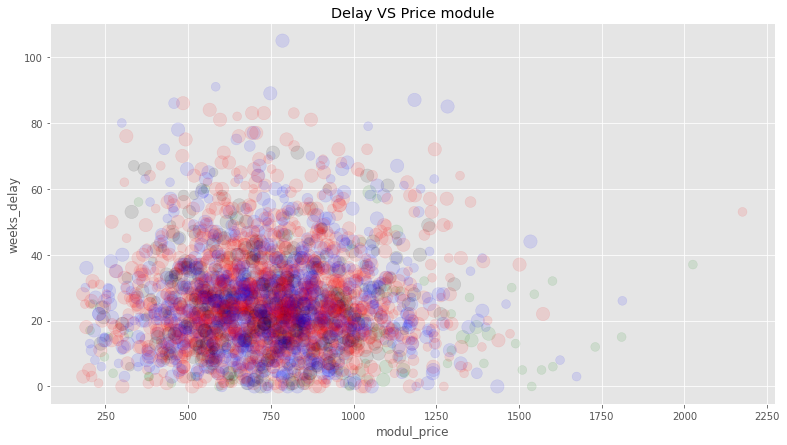

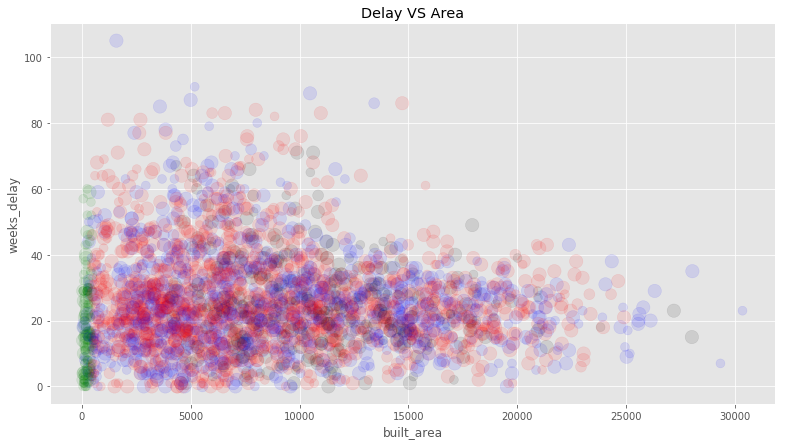

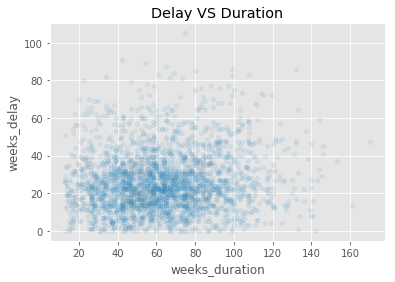

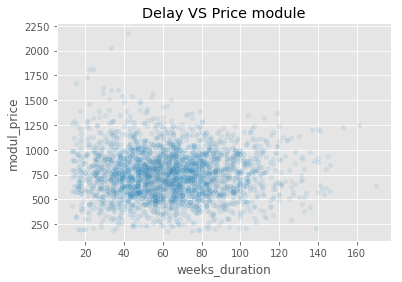

In [6]:
#Creamos una lista de colores según las tipologías de la columna "tipolog".

color= ['black' if l == "COMMERCIAL" else 'blue' if l == "OTHERS" else 'green' if l== "DETACHED" 
        else 'red' for l in const_tot["typology"]]

#Creating a list to assign size of the plots to a variable. 
#This case we will use the construction duration.
size= [20 if n < 13 else 80 if n <50 else 180 if n <100 else 120
         for n in const_tot["weeks_duration"]]

#Scatterplotting to see the distribution:
const_tot.plot.scatter(x='modul_price', y="weeks_delay", title="Delay VS Price module",
                       color=color, alpha=0.1,figsize=(13, 7),s=size)
const_tot.plot.scatter(x="built_area", y="weeks_delay", title="Delay VS Area",
                       color=color, alpha=0.1,figsize=(13, 7),s=size)
const_tot.plot.scatter(x="weeks_duration", y="weeks_delay", title="Delay VS Duration", alpha=0.1)
const_tot.plot.scatter(x="weeks_duration", y='modul_price', title="Delay VS Price module", alpha=0.1)

## Visualizing the Data:

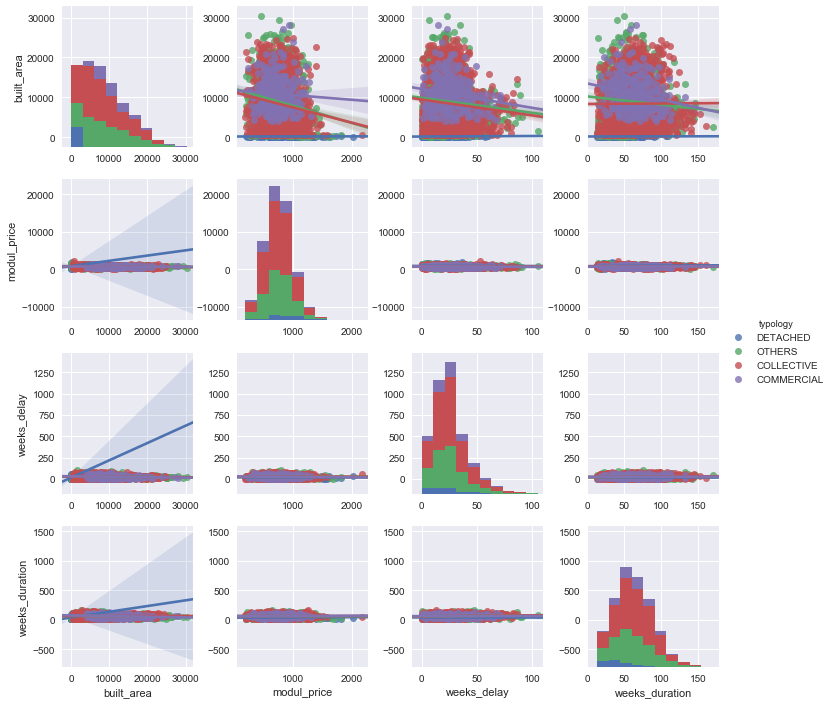

In [7]:
import seaborn as sns
sns.set()
sns.pairplot(const_tot, hue="typology",kind="reg")

In [8]:
list(np.unique(const_tot["typology"]))

['COLLECTIVE', 'COMMERCIAL', 'DETACHED', 'OTHERS']

In [9]:
#Let's see if everything is OK:
print(const_tot[["typology", "built_area"]].groupby(["typology"], as_index=False).max())
print(const_tot[["typology", "built_area"]].groupby(["typology"], as_index=False).describe())
print(const_tot.sample(10))

     typology    built_area
0  COLLECTIVE  24902.791106
1  COMMERCIAL  28021.015018
2    DETACHED    441.571677
3      OTHERS  30346.912630
  built_area                                                       \
       count          mean          std          min          25%   
0     1442.0   8425.804522  5578.118357   459.038343  3960.496834   
1      298.0  10906.120249  4106.458844  4113.586535  7634.867929   
2      131.0    221.239810   117.013792    50.187191   122.896406   
3      934.0   8942.583084  6027.303585    73.024390  4121.610739   

                                             
            50%           75%           max  
0   7061.340409  11770.945576  24902.791106  
1  10557.064865  13516.305352  28021.015018  
2    220.894504    309.072372    441.571677  
3   7715.460971  13236.679579  30346.912630  
        built_area  modul_price  weeks_delay  weeks_duration    typology
161     477.802620   833.766319            3              46  COLLECTIVE
2149  14526.403977   80

In [10]:
#One Hot Encoding (OHE) building typologies for better future processing:

detached=[1 if n =="DETACHED" else 0 for n in const_tot["typology"]]
collective=[1 if n =="COLLECTIVE" else 0 for n in const_tot["typology"]]
commercial=[1 if n =="COMMERCIAL" else 0 for n in const_tot["typology"]]
others=[1 if n =="OTHERS" else 0 for n in const_tot["typology"]]

const_OHE = pd.DataFrame()
const_OHE["DETACHED"]  = pd.Series(detached)
const_OHE["COLLECTIVE"] = pd.Series(collective)
const_OHE["COMMERCIAL"] = pd.Series(commercial)
const_OHE["OTHERS"]= pd.Series(others)

#One Hot Encoding (OHE) delays depending of the delays and the duration, assigning a threshold based in 
# the minimum proportion of 0.15 times the duration to consider it a TRUE delay:

def divide(x):
    return np.divide(x['weeks_delay'],x['weeks_duration'])

delays = pd.DataFrame()
delays = const_tot.apply(divide,axis=1)
const_OHE["DELAYED"] = [1 if n > 0.2  else 0 for n in delays]
const_OHE.sample(5)

,DETACHED,COLLECTIVE,COMMERCIAL,OTHERS,DELAYED
1455,0,1,0,0,0
1649,0,1,0,0,1
1619,0,0,0,1,1
1857,0,0,0,1,1
1734,0,0,0,1,1


In [21]:
#Checking de coherence of the new one hot encoded DF.
check_df = pd.concat([const_tot,const_OHE],axis=1)
check_df.head(5)

,built_area,modul_price,weeks_delay,weeks_duration,typology,DETACHED,COLLECTIVE,COMMERCIAL,OTHERS,DELAYED
0,87.319237,746.234909,10,56,DETACHED,1,0,0,0,0
1,443.520822,740.714102,17,21,OTHERS,0,0,0,1,1
2,75.048001,1044.606187,2,46,DETACHED,1,0,0,0,0
3,315.313721,1066.145384,16,62,DETACHED,1,0,0,0,1
4,248.142688,1568.085165,5,29,DETACHED,1,0,0,0,0


In [12]:
#Concatenating main DF with the one hot encoded DF and dropping redundant columns:
prepared_const = const_tot.drop(['typology','weeks_delay'],axis=1)
prepared_const = pd.concat([prepared_const,const_OHE],axis=1)

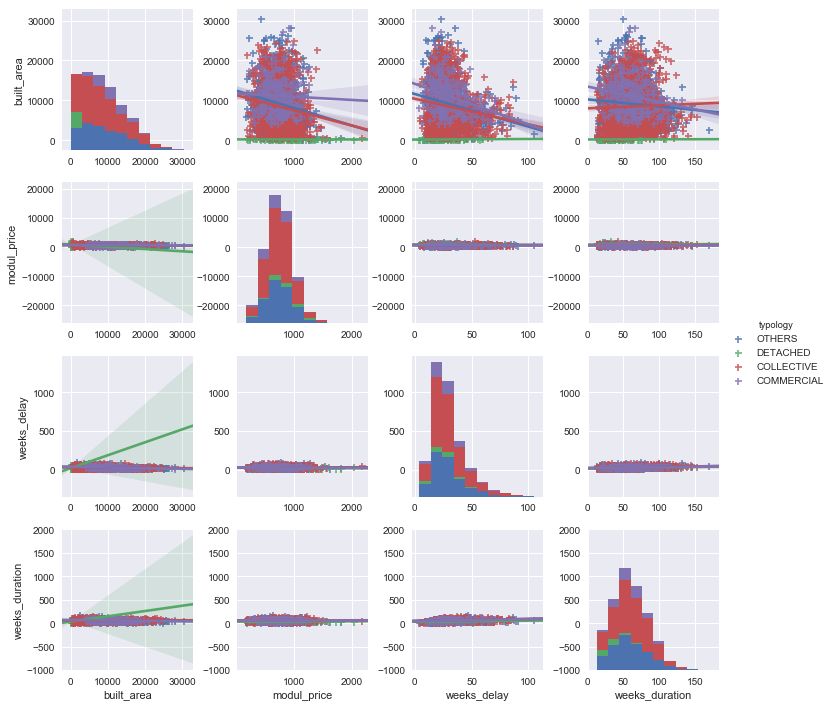

In [13]:
#Preview of the Data Set, looking for correlations. Let's filter the DF with the bigger grop of the target, 
#observations DELAYED = True.
preview_const = pd.concat([const_tot,const_OHE['DELAYED']],axis=1)
import seaborn as sns
sns.set()
sns.pairplot(const_tot[preview_const['DELAYED'] == 1], hue="typology",markers="+",kind="reg")

In [29]:
const_tot.describe()

,built_area,modul_price,weeks_delay,weeks_duration
count,2805.000000,2805.000000,2805.000000,2805.000000
mean,8478.213536,754.257323,25.523708,62.869875
std,5809.476294,238.039481,15.201590,25.394712
min,50.187191,182.575720,0.000000,13.000000
25%,3900.754148,588.662019,15.000000,44.000000
50%,7428.395475,745.238307,23.000000,61.000000
75%,12278.344936,902.208945,33.000000,79.000000
max,30346.912630,2175.327794,105.000000,170.000000


In [37]:
print(const_tot['built_area'].mean())
print(const_tot['built_area'].std())

8478.213536378209
5809.476294189178


In [59]:

def stdscaler(vector):
    for i in vector:        
        x = (i - mean)/std
        return x
x= stdscaler(const_tot['built_area'])
x

-1.4443460777086612

In [69]:
vector = [(87.319237 ,746.234909 ,10 ,56)]

    

X_normalized = const_tot['built_area'].apply(stdscaler)
X_normalized.head(5)

0   -1.444346
1   -1.383032
2   -1.446458
3   -1.405101
4   -1.416663
Name: built_area, dtype: float64

In [70]:
prepared_const.head(5)

,built_area,modul_price,weeks_duration,DETACHED,COLLECTIVE,COMMERCIAL,OTHERS,DELAYED
0,-1.444604,-0.033708,-0.270572,1,0,0,0,0
1,-1.383279,-0.056905,-1.649058,0,0,0,1,1
2,-1.446716,1.219968,-0.664425,1,0,0,0,0
3,-1.405351,1.310470,-0.034260,1,0,0,0,1
4,-1.416916,3.419487,-1.333975,1,0,0,0,0


## Feature scaling

In [36]:
#Feature Scaling:
scaler = preprocessing.StandardScaler()

scaled_const = pd.DataFrame(scaler.fit_transform(
    prepared_const[['built_area', 'modul_price','weeks_duration']]),
                            columns= ['built_area', 'modul_price','weeks_duration'])
prepared_const = pd.concat([scaled_const,prepared_const.drop(['built_area', 'modul_price','weeks_duration'],axis=1)],
                        axis=1)
prepared_const.describe()

,built_area,modul_price,weeks_duration,DETACHED,COLLECTIVE,COMMERCIAL,OTHERS,DELAYED
count,2.805000e+03,2.805000e+03,2.805000e+03,2805.000000,2805.000000,2805.000000,2805.000000,2805.000000
mean,2.355810e-16,2.455948e-16,-1.800510e-16,0.046702,0.514082,0.106239,0.332977,0.805348
std,1.000178e+00,1.000178e+00,1.000178e+00,0.211038,0.499891,0.308198,0.471362,0.396003
min,-1.450996e+00,-2.402053e+00,-1.964140e+00,0.000000,0.000000,0.000000,0.000000,0.000000
25%,-7.880703e-01,-6.957872e-01,-7.431957e-01,0.000000,0.000000,0.000000,0.000000,1.000000
50%,-1.807401e-01,-3.789550e-02,-7.364559e-02,0.000000,1.000000,0.000000,0.000000,1.000000
75%,6.542430e-01,6.216532e-01,6.352898e-01,0.000000,1.000000,0.000000,1.000000,1.000000
max,3.764986e+00,5.970958e+00,4.219352e+00,1.000000,1.000000,1.000000,1.000000,1.000000


In [15]:
#Let's split the dataset and train the model:
y = prepared_const['DELAYED']
X = prepared_const.loc[:,'built_area':'OTHERS']

X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.15,random_state=1,stratify=y)

In [19]:
list(prepared_const)

['built_area',
 'modul_price',
 'weeks_duration',
 'DETACHED',
 'COLLECTIVE',
 'COMMERCIAL',
 'OTHERS',
 'DELAYED']

In [16]:
y[y_test.index.values].head(5)

2594    0
152     1
468     1
2596    1
2737    1
Name: DELAYED, dtype: int64

## Test and combination of ML models:
Due to the impossibility for the client (construction managers) most of the times, to manipulate every parameter in the construction project, it is useless to recomend global optimal parameters. So the nature of this problem force us to focus in local optima rather than on globals. So, we have to refine the models to avoid overfitting, but taking care of not "softening" the models too much. With the confussion matrix in mind, so we are open to have a model with many False Positives (of potentially delayed construction projects but finally not delayed). This way we won't take the risk of regularizing the models too much nd loosing valuable information.

In [17]:
#K-NEIGHBORS:
knn =KNeighborsClassifier(n_neighbors=10)
knn.fit(X,y)
y_pred_kn = knn.predict(X_test)
print("KNEIGHBORS REGRESSION MODEL: ")
print("Basic scoring: " +str(knn.score(X_test,y_test)))
print("Normalized accuracy: " +str(accuracy_score(y_test,y_pred_kn)))
print("Net accuracy: " +str(accuracy_score(y_test,y_pred_kn, normalize = False)) + 
      " over " + str(y_test.size) + " samples.")

KNEIGHBORS REGRESSION MODEL: 
Basic scoring: 0.814726840855
Normalized accuracy: 0.814726840855
Net accuracy: 343 over 421 samples.


In [92]:
#Single prediction:
prediction = knn.predict([[7966.539337 ,952.116206, 71 ,0 , 1,0,0]])
prediction

array([1], dtype=int64)

In [93]:
#LOGISTIC:
logreg = LogisticRegression()
logreg.fit(X_train, y_train)
y_pred_lg = logreg.predict(X_test)
print("LOGISTIC REGRESSION MODEL: ")
print("Basic scoring: " +str(logreg.score(X_test,y_test)))
print("Normalized accuracy: " +str(accuracy_score(y_test,y_pred_lg)))
print("Net accuracy: " +str(accuracy_score(y_test,y_pred_lg, normalize = False)) + 
      " over " + str(y_test.size) + " samples.")


LOGISTIC REGRESSION MODEL: 
Basic scoring: 0.8138424821
Normalized accuracy: 0.8138424821
Net accuracy: 341 over 419 samples.


In [95]:
#RANDOM FOREST CLASSIF:
ranfor = RandomForestClassifier(max_depth=2, random_state=0)
ranfor.fit(X, y)
y_pred_rf = ranfor.predict(X_test)
print("RANDOM FOREST MODEL: ")
print("Basic scoring: " +str(ranfor.score(X_test,y_test)))
print("Normalized accuracy: " +str(accuracy_score(y_test,y_pred_rf)))
print("Net accuracy: " +str(accuracy_score(y_test,y_pred_rf, normalize = False)) + 
      " over " + str(y_test.size) + " samples.")

RANDOM FOREST MODEL: 
Basic scoring: 0.8138424821
Normalized accuracy: 0.8138424821
Net accuracy: 341 over 419 samples.


# Evaluating ML tools performance and combination:
As we will see, the performance and predictions of random forest and logistic regression tools are similar, probably because of the scarcity of samples. We will combine these tools only to score the confidence of the prediction, as they will predict the same labels most of the times.

In [96]:
#Coincidence between models:
print("LOGIST VS RANDFOR: " +str(accuracy_score(y_pred_lg,y_pred_rf)))
print("LOGIST VS K-NEIGH: " +str(accuracy_score(y_pred_lg,y_pred_kn)))
print("RANDFOR VS K-NEIGH: " +str(accuracy_score(y_pred_rf,y_pred_kn)))

LOGIST VS RANDFOR: 0.990453460621
LOGIST VS K-NEIGH: 0.935560859189
RANDFOR VS K-NEIGH: 0.935560859189
